In [4]:
#Libraries
using Turing
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Distances
using Random
using Plots
using VectorizedRoutines;

┌ Info: Precompiling VectorizedRoutines [0e69188a-a5d4-5622-b4e4-a72373136fc5]
└ @ Base loading.jl:1260


In [5]:
#Hyperparameters
n = 10
N = 300
σₐ = 0.001
bound = 1

k_range = 100
k_list = [Int(i) for i=1:100] #November 3
#k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
k_list_lite = [i for i in 1:k_range]
k_true = 20
k = k_true;

#Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha)
    #PyPlot.colorbar()
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

mₖ(k) = k*4 + 1;

In [6]:
#Generative Interpolator Network

#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    #if(typeof(x) == Float64)
        #x = [x]
    #end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, sigmoid),
               Dense(W₂, b₂))
    return nn(x)
end;

#Create a Random Network
@model function generator(Wₕ, bₕ, Wₒ, bₒ, k)
    α = 0.009 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ MvNormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ MvNormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ MvNormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ MvNormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    #scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    #scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))
    return Wₕ, bₕ, Wₒ, bₒ
    
end;

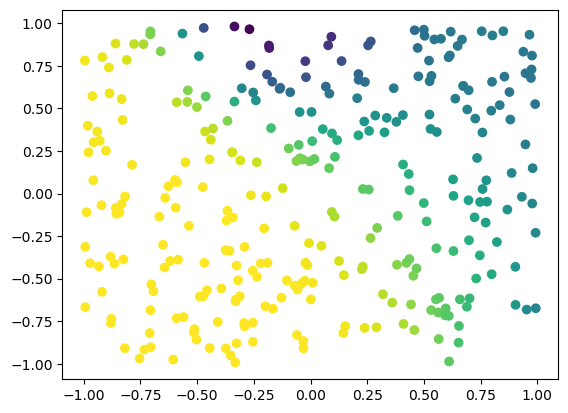

PyObject <matplotlib.collections.PathCollection object at 0x00000000648E3190>

In [15]:
#Generate Sample Data
k_real = 12
simulation = generator(missing, missing, missing, missing, k_real)
Wₕ, bₕ, Wₒ, bₒ, = simulation()

#Generate Network Parameters and Corresponding Curve
#obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

#(trace,) = generate(generator, (x, k_real), obs)

#Wₕ = trace[:Wₕ]
#Wₒ = trace[:Wₒ]
#bₕ = trace[:bₕ]
#bₒ = trace[:bₒ]

#y_real = Flux.σ.(G(x.*100000,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
y_real = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
#print(y_real)

y_fake = rand(Uniform(0,1),(N))
#y_real = y_fake
plot_data(x_raw,y_real)

In [16]:
#Now we try to learn the generator
@model interpolator(x, y, k) = begin
    α = 0.09 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k ~ Categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    #Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Σ₁ = σₖ .* ones(length(μ₁))
    a ~ MvNormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    #Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    Σ₂ = σₖ .* ones(length(μ₂))
    b ~ MvNormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    #Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Σ₃ = σₖ .* ones(length(μ₃))
    c ~ MvNormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    #Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    Σ₄ = σₖ .* ones(length(μ₄))
    d ~ MvNormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,a,b,c,d,k_real)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y ~ MvNormal(vec(scores), 0.001 .* [i for i=1:length(x[1,:])])
    #return y, Wₕ, bₕ, Wₒ, bₒ, k
    
end;

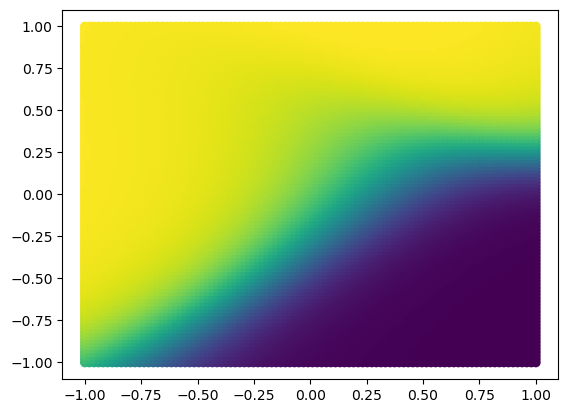

6

PyObject <matplotlib.collections.PathCollection object at 0x0000000064A7C760>

In [17]:
#Test out interpolator
chain = sample(interpolator(x, missing, missing), Prior(), 1)
a = collect(Iterators.flatten(get_params(chain).a))
b = collect(Iterators.flatten(get_params(chain).b))
c = collect(Iterators.flatten(get_params(chain).c))
d = collect(Iterators.flatten(get_params(chain).d))
tk = Int(get_params(chain).k[1]);
ty = collect(Iterators.flatten(get_params(chain).y))

print(tk)
plot_data(x_raw,ty);

function creategrid(d::Integer, n::Integer, low::Float64, high::Float64)

    @assert d >= 1 ("d (number of dimensions) must be a positive integer")
    @assert n >= 2 ("n (number of points) must be a at least 2")

    r = range(low, high, length = n)

    iter = Iterators.product((r for _ in 1:d)...)

    return vec([collect(i) for i in iter])
end

grid = creategrid(2,100,-1.0,1.0)
grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
grid2 = transpose(grid_raw)
z = Flux.σ.(G(grid2,a,b,c,d,tk))[1,:];
plot_data(grid_raw, z)

In [26]:
get_params(chain).lp[1]

180.2993548121891

In [22]:
#Likelihood sampling
scores = []
distances = []
ks = []
best_ks = []
best_traces = []

best_chain = sample(interpolator(x, y_real, missing), Prior(), 1)
a = collect(Iterators.flatten(get_params(chain).a))
b = collect(Iterators.flatten(get_params(chain).b))
c = collect(Iterators.flatten(get_params(chain).c))
d = collect(Iterators.flatten(get_params(chain).d))
best_k = Int(get_params(chain).k[1]);

best_score = best_chain[:lp][1]
#println(best_score)
best_pred_y = Flux.σ.(G(x,a,b,c,d,best_k))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_dist, best_score, best_k)
    chain = sample(interpolator(x, y_real, missing), Prior(), 1)
    
    a = collect(Iterators.flatten(get_params(chain).a))
    b = collect(Iterators.flatten(get_params(chain).b))
    c = collect(Iterators.flatten(get_params(chain).c))
    d = collect(Iterators.flatten(get_params(chain).d))
    k = Int(get_params(chain).k[1]);
    pred_y = Flux.σ.(G(x,a,b,c,d,k))

    #dist = sqrt(sum((pred_y .- y_real) .^ 2))
    dist = euclidean(pred_y, y_real)
    score = chain[:lp][1]
    #println(score)
    #println(score)
    if dist < best_dist
        best_dist = dist
        best_score = score
        best_chain = chain
        best_pred_y = pred_y
        best_k = k
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    push!(ks, k)
    #println(best_score)
    return(best_dist, best_score, best_k)
end

for i=1:10
    best_dist, best_score, best_k = likelihood(best_dist, best_score, best_k)
    push!(best_ks, best_k)
end

#PyPlot.scatter(distances, scores)
#plt.title("Comparing Classifier Accuracy to Log Likelihood")
#plt.xlabel("Classifier Accuracy")
#plt.ylabel("Log Likelihood")
#plt.legend()

In [453]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(chain, current_k)
    
    if current_k == last(k_list)
        new_chain = death(chain)
    elseif current_k == k_list[1]
        new_chain = birth(chain)
    else
        new_chain, new_k = rand(Bernoulli(0.5)) ? birth(chain, current_k) : death(chain, current_k)
    end
    return new_chain, new_k
    
end

function birth(chain, previous_k)

    new_k = k_list[previous_k + 1]
    difference = abs(new_k - previous_k)
    
    a = collect(Iterators.flatten(get_params(chain).a))
    b = collect(Iterators.flatten(get_params(chain).b))
    c = collect(Iterators.flatten(get_params(chain).c))
    d = collect(Iterators.flatten(get_params(chain).d))
    
    new_chain = sample(interpolator(x, y_real, new_k), Prior(), 1)
    
    return new_chain, new_k

end

function death(chain, previous_k)

    new_k = k_list[previous_k - 1]
    difference = abs(previous_k - new_k)
    
    a = collect(Iterators.flatten(get_params(chain).a))
    b = collect(Iterators.flatten(get_params(chain).b))
    c = collect(Iterators.flatten(get_params(chain).c))
    d = collect(Iterators.flatten(get_params(chain).d))
    
    new_chain = sample(interpolator(x, y_real, new_k), Prior(), 1)
    
    return new_chain, new_k
    
end;

In [462]:
chains_list = []
acc = []
acc_a = []
acc_w = []
ks = []

function within_dimension(chain, iters, k)
    for i=1:iters
        new_chain = sample(interpolator(x, y_real, k), NUTS(0.65), 1)
        accepted = (new_chain[:is_accept] == 1.0) ? true : false
        if accepted 
            chain = new_chain
        end
        push!(chains_list, chain)
        push!(acc, accepted)
        push!(acc_w, accepted)
        #accepted && println("Within accepted")
    end
    return chain
end

function across_dimension(chain, iters, k)
    
    new_chain, new_k = birth_or_death(chain, k)
    
    #test = true
    for i=1:iters
        new_chain = sample(interpolator(x, y_real, new_k), NUTS(0.65), 1)
        #test = (new_chain[:is_accept][1] == 1.0) ? false : true
    end
    #test && println("Nothing accepted")
    
    score1 = chain[:lp][1]
    score2 = new_chain[:lp][1]
    logscore = (score2 - score1)
    score = exp(logscore)
    #println(score)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        chain = new_chain
        k = new_k
        #println("New k accepted! Current k: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
        
    push!(chains_list, chain)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return chain, k
end

function rjmcmc(starting_chain, iters)
    chain = starting_chain
    k = Int(get_params(chain).k[1])
    println("Beginning RJMCMC. Starting k: $k")

    for i=1:iters

        if i%10 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #print(obs[:k])
        end
        
        if rand(Uniform(0,1)) > 1.0
            (chain, k) = across_dimension(chain, 1, k)
        else
            (chain) = within_dimension(chain, 1)
        end
        push!(ks, k)
    end
    
    println("Finished")
end
 
runs = 200
#starting_chain = best_chain
starting_chain = sample(interpolator(x, y_real, missing), Prior(), 1)
k = Int(get_params(starting_chain).k[1])
rjmcmc(starting_chain,runs);

Beginning RJMCMC. Starting k: 66


UndefVarError: UndefVarError: select not defined

In [445]:
new_chain = sample(interpolator(x, y_real, 12), NUTS(0.65), 1)
test = (new_chain[:is_accept][1] == 1.0) ? false : true

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/jberez/.julia/packages/Turing/3goIa/src/inference/hmc.jl:625


false

In [394]:
new_chain[:is_accept][1]
if Int(1.

TypeError: TypeError: non-boolean (Int64) used in boolean context